In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, \
                                    cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, \
    recall_score, accuracy_score, make_scorer, roc_curve, auc, f1_score, \
        mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, \
                                    OrdinalEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, AdaBoostRegressor, \
    GradientBoostingRegressor, BaggingRegressor, RandomForestClassifier, StackingClassifier, \
    AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as metrics
import winsound

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

np.random.seed(13)

C:\Users\rahul\.conda\envs\tf\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
def nested_cross_validation(training_X, training_Y, classifiers, \
        custom_scorer, clf_dict, inner_n_splits = 4, outer_n_splits = 4, verbose = 0, njobs = 1):
#     non_nested_scores = []
    nested_scores = []
    for clf, param_grid in clf_dict.items():        
        if clf["model"].__class__.__name__ not in classifiers:
            continue
        inner_cv = KFold(n_splits=inner_n_splits, shuffle=True, random_state=42)
        outer_cv = KFold(n_splits=outer_n_splits, shuffle=True, random_state=42)
        # Non_nested parameter search and scoring
        # clf_inner = GridSearchCV(estimator=clf, param_grid=param_grid, cv=outer_cv, \
                                #  scoring = custom_scorer)
        # clf_inner.fit(training_X, training_Y)
        # non_nested_scores.append((clf, clf_inner.best_score_))
        print("Currently Executing:- ")
        print(clf, param_grid)
        clf_inner = GridSearchCV(estimator=clf, param_grid=param_grid, cv=inner_cv, \
                                 scoring = custom_scorer, verbose=verbose, n_jobs = njobs)
        #Scaling should be done in the outer loop too
        clf_inner_2 = Pipeline([('scaler', clf.steps[0][1]), ('gridsearch', clf_inner)])
        nested_score = cross_val_score(clf_inner_2, X=training_X, y=training_Y, cv=outer_cv, \
                                       scoring = custom_scorer, verbose = verbose, n_jobs= njobs)
        nested_scores.append((clf, nested_score.mean()))
    return nested_scores

In [3]:
def get_best_model_regression(training_X, training_Y, testing_X, \
                    testing_Y, regressor_dict, nested_scores, scorer, verbose = 0, njobs = 1):
    #Select best classification based on the nested scores
    best_classifier = max(nested_scores, key=lambda item:-(item[1]))[0]
    clf = GridSearchCV(best_classifier, regressor_dict[best_classifier], scoring= scorer, verbose = verbose, n_jobs=njobs)
    clf.fit(training_X, training_Y)
    
    #Training the model found with the best paramaters
    best_params = clf.best_params_
    best_classifier.set_params(**best_params)
    
    best_classifier.fit(training_X, training_Y)

    #Testing on the unseen data and producing the confusion matrix
    y_pred = best_classifier.predict(testing_X)

    y_true = testing_Y
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    return best_classifier

In [4]:
def get_best_model_classification(training_X, training_Y, testing_X, \
                    testing_Y, classifier_dict, nested_scores, scorer="accuracy", verbose = 0, njobs = 1):
    #Select best classification based on the nested scores
    best_classifier = max(nested_scores, key=lambda item:item[1])[0]
    clf = GridSearchCV(best_classifier, classifier_dict[best_classifier], scoring= scorer, verbose = verbose, n_jobs=njobs)
    clf.fit(training_X, training_Y)
    
    #Training the model found with the best paramaters
    best_params = clf.best_params_
    best_classifier.set_params(**best_params)
    
    best_classifier.fit(training_X, training_Y)

    #Testing on the unseen data and producing the confusion matrix
    test_pred = best_classifier.predict(testing_X)

    print("******************CONFUSION MATRIX******************")
    
    print(confusion_matrix(testing_Y, test_pred))

    
    print("****************CLASIFICATION REPORT****************")
    
    df = pd.DataFrame(classification_report(testing_Y, test_pred, output_dict=True))
    print(df)
    return best_classifier

In [5]:
def create_neural_regression_model(input_dim = None, activation='relu', nb_hidden=10, nb_hidden_2=10, metric = "mean_squared_error", loss = 'mean_squared_error', classes = 1, optimizer = "adam"):
    model = Sequential()
    model.add(Dense(units = nb_hidden, input_dim = input_dim, activation="relu"))
    model.add(Dense(units = nb_hidden_2, activation="relu"))
    model.add(Dense(1))
    model.compile(loss= loss, optimizer=optimizer, metrics=[metric])
    return model

In [6]:
def create_neural_classification_model(input_dim, activation='relu', activation_final = "sigmoid", nb_hidden=10, nb_hidden_2=10, metric = "accuracy", loss = 'categorical_crossentropy', classes = 2, optimizer = "adam"):
    model = Sequential()
    model.add(Dense(nb_hidden, input_dim, activation=activation))
    model.add(Dense(nb_hidden_2, activation=activation))
    model.add(Dense(classes), activation = activation_final)
    model.compile(loss= loss, optimizer= optimizer, metrics=[metric])
    return model

#Spending Regression

In [7]:
data_1 = pd.read_excel("spending.xlsx")

#### Splitting the data into Train, Eval and Test

train_set_1, test_set_1 = train_test_split(data_1, test_size = 0.2, \
                                random_state = 43, stratify=data_1[["US", "Address_is_res"]])

train_X_1 = train_set_1.drop(["sequence_number", "Spending"], axis = 1)
train_Y_1 = train_set_1["Spending"]

test_X_1 = test_set_1.drop(["sequence_number", "Spending"], axis = 1)
test_Y_1 = test_set_1["Spending"]

#### Exploring the dataset

print(train_set_1.head())

print(train_set_1.info())

      sequence_number  US  source_a  source_c  source_b  source_d  source_e  \
1895             1896   1         0         0         0         0         0   
584               585   1         0         0         0         0         0   
1349             1350   1         0         1         0         0         0   
792               793   1         0         0         0         0         0   
800               801   1         0         0         0         0         0   

      source_m  source_o  source_h  ...  source_x  source_w  Freq  \
1895         0         0         0  ...         0         0     1   
584          0         0         0  ...         0         0     3   
1349         0         0         0  ...         0         0     3   
792          0         0         0  ...         1         0     1   
800          0         0         1  ...         0         0     2   

      last_update_days_ago  1st_update_days_ago  Web order  Gender=male  \
1895                  3047         

In [10]:
train_set_1.describe()

sequence_number           US     source_a     source_c     source_b  \
count      1600.000000  1600.000000  1600.000000  1600.000000  1600.000000   
mean       1009.856875     0.824375     0.131875     0.050625     0.063125   
std         576.168763     0.380620     0.338461     0.219299     0.243264   
min           1.000000     0.000000     0.000000     0.000000     0.000000   
25%         519.500000     1.000000     0.000000     0.000000     0.000000   
50%        1013.500000     1.000000     0.000000     0.000000     0.000000   
75%        1509.250000     1.000000     0.000000     0.000000     0.000000   
max        2000.000000     1.000000     1.000000     1.000000     1.000000   

         source_d     source_e     source_m     source_o     source_h  ...  \
count  1600.00000  1600.000000  1600.000000  1600.000000  1600.000000  ...   
mean      0.04125     0.145000     0.013750     0.032500     0.049375  ...   
std       0.19893     0.352211     0.116488     0.177379     0.216717  ...   
min       0.00000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.00000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.00000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.00000     0.000000     0.000000     0.000000     0.000000  ...   
max       1.00000     1.000000     1.000000     1.000000     1.000000  ...   

          source_x     source_w         Freq  last_update_days_ago  \
count  1600.000000  1600.000000  1600.000000           1600.000000   
mean      0.020000     0.138125     1.410625           2160.494375   
std       0.140044     0.345139     1.398028           1142.300921   
min       0.000000     0.000000     0.000000              7.000000   
25%       0.000000     0.000000     1.000000           1134.000000   
50%       0.000000     0.000000     1.000000           2298.500000   
75%       0.000000     0.000000     2.000000           3148.750000   
max       1.000000     1.000000    15.000000           4188.000000   

       1st_update_days_ago    Web order  Gender=male  Address_is_res  \
count          1600.000000  1600.000000  1600.000000     1600.000000   
mean           2439.191875     0.428125     0.521250        0.221250   
std            1081.954758     0.494962     0.499704        0.415218   
min               7.000000     0.000000     0.000000        0.000000   
25%            1664.750000     0.000000     0.000000        0.000000   
50%            2724.000000     0.000000     1.000000        0.000000   
75%            3357.000000     1.000000     1.000000        0.000000   
max            4188.000000     1.000000     1.000000        1.000000   

          Purchase     Spending  
count  1600.000000  1600.000000  
mean      0.501250   101.896012  
std       0.500155   186.657510  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       1.000000     3.355000  
75%       1.000000   150.625000  
max       1.000000  1446.000000  

[8 rows x 25 columns]

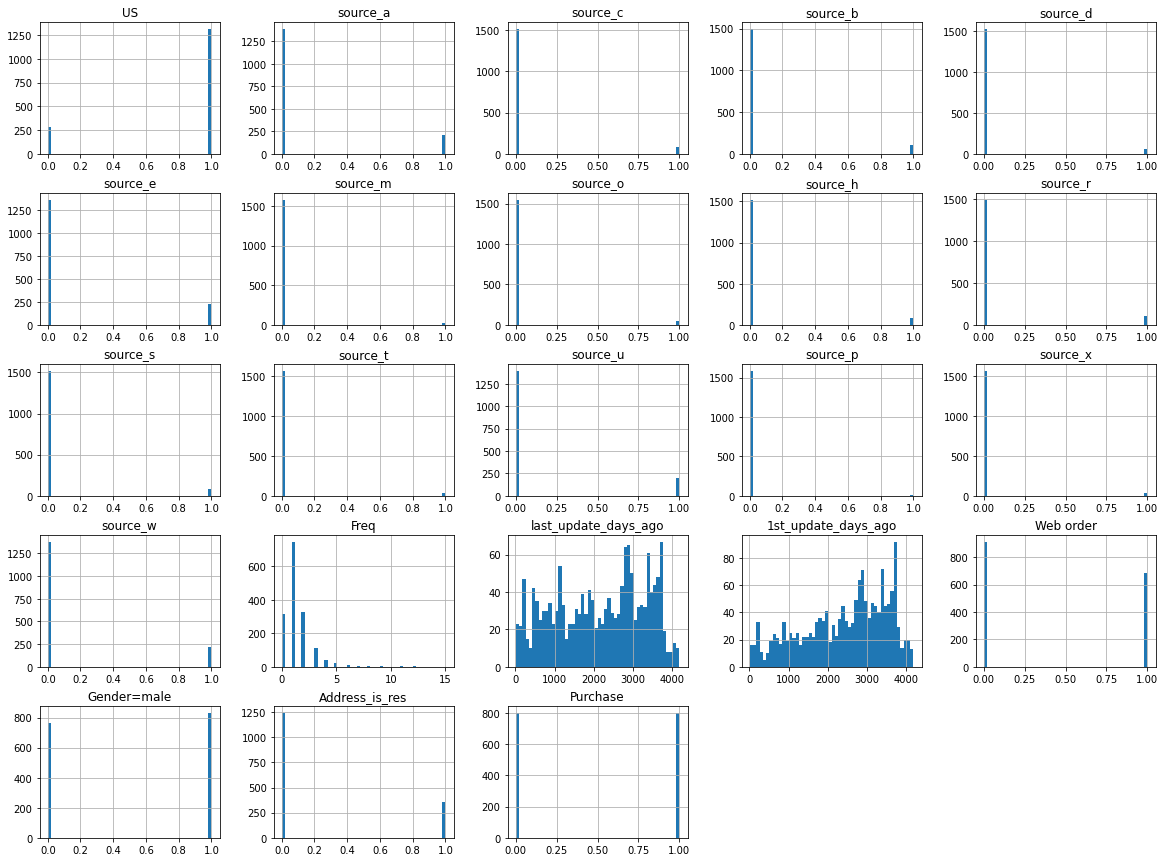

In [11]:
train_X_1.hist(bins = 50, figsize=(20,15))
plt.show()

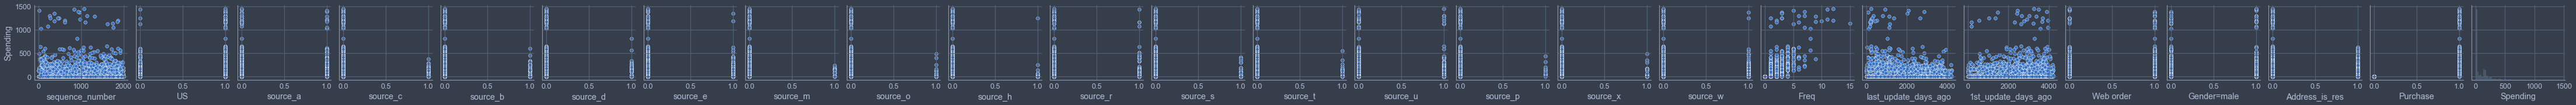

In [5]:
sns.pairplot(train_set_1, y_vars="Spending", x_vars=train_set_1.columns.values)

In [8]:
#### Nested Grid Search

#Defining the 4 classifiers and also adding min max scaling before every 
    #classifier fitting in the cross validation as the models 
    #knn requires minmaxscaling, 
    #logistic regression and svc require normalization

#Applying scaling in the inner loop before training the model

reg_1 = Pipeline([('scaler', None), ('model', DecisionTreeRegressor())])

reg_2 = Pipeline([('scaler', MinMaxScaler()), ('model', KNeighborsRegressor())])

reg_3 = Pipeline([('scaler', StandardScaler()), ('model', ElasticNet())])

reg_4 = Pipeline([('scaler', StandardScaler()), ('model', SVR())])

reg_5 = Pipeline([('scaler', None), ("model", RandomForestRegressor())])

reg_6 = Pipeline([("scaler", None), ("model", AdaBoostRegressor())])

reg_7 = Pipeline([("scaler", None), ("model", GradientBoostingRegressor())])

reg_8 = Pipeline([("scaler", StandardScaler()), ("model", XGBRegressor())])

reg_9 = Pipeline([("scaler", StandardScaler()), ("model", LGBMRegressor())])

reg_10 = Pipeline([("scaler", None), ("model", KerasRegressor(build_fn=create_neural_regression_model))])

C:\Users\rahul\AppData\Local\Temp\ipykernel_29852\2718731799.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  reg_10 = Pipeline([("scaler", None), ("model", KerasRegressor(build_fn=create_neural_regression_model))])


In [10]:
#Defining parameter grids for grid search
regression_dict_base = {
    #Decision Trees
    reg_1 : {
        "model__criterion" : ["friedman_mse", "squared_error", "absolute_error"],
        "model__max_depth" : list(range(3, 8))
    },
    #KNN
    reg_2 : {
        "model__n_neighbors" : list(range(3, 8)),
        "model__weights" : ["distance", "uniform"]
    },
    #Linear Regression ElasticNet
    reg_3 : 
    {
        "model__alpha" : [0, 0.01, 0.1, 1, 10, 100, 1000],
        "model__l1_ratio" : [0, 0.5, 1]
    },
    #SVR
    reg_4 :
    {
        "model__C" : [0.001, 0.01, 0.1, 1],
        "model__kernel" : ["linear", "rbf"],
        "model__gamma" : ["auto", "scale"],
        "model__epsilon" : [0.01, 0.1, 0.5, 0.9]
    },
    #Random Forest
    reg_5 : {"model__n_estimators" : [100, 1000],
            "model__criterion" : ["squared_error", "absolute_error", "poisson"],
            "model__max_depth" : list(range(3, 10)),
            "model__oob_score" : [True, False]},
    #AdaBoost Regression
    reg_6 : {"model__n_estimators" : [100, 1000],
            "model__learning_rate" : [0.03, 0.1, 0.3, 1],
            "model__loss" : ["linear", "square", "exponential"]},
    #GradientBoost Regression
    reg_7 : {"model__n_estimators" : [100, 1000],
            "model__learning_rate" : [0.1, 1, 0.01],
            "model__loss" : ["huber", "squared_error", "absolute_error", "quantile"],
            "model__criterion" : ["friedman_mse", "squared_error"]},
    #XGB Regression
    reg_8 : {
        "model__n_estimators" : [100, 1000],
        "model__max_depth" : list(range(3, 12)),
        "model__learning_rate" : [0.1, 1, 0.01, 10]
    },
    #LGBM Regression
    reg_9 : {
        "model__n_estimators" : [100, 1000],
        "model__max_depth" : list(range(3, 12)),
        "model__learning_rate" : [0.1, 1, 0.01],
        "model__num_leaves" : [20, 30, 40],
        
    },
    reg_10 : {
        "model__nb_hidden" : [10],
        "model__nb_hidden_2" : [10],
        "model__activation" : np.array(['relu']),
        "model__optimizer" : ["rmsprop", "adam"],
            # Adam(learning_rate=1e-4), Adam(learning_rate=1e-3), Adam(learning_rate=1e-2), 
        "model__epochs" : [1000],
        "model__batch_size" : [256],
        "model__callbacks" : [EarlyStopping(monitor='loss', patience=3)]
    }
    #StackingRegressor
#     reg_9 : {
#         'model__max_depth': [2, 3, 5, 7, 10],
#         'model__n_estimators': [10, 100, 500],
#     },
#     reg_10 : {
#         'model__max_depth': [2, 3, 5, 7, 10],
#         'model__n_estimators': [10, 100, 500],
#     }
}

In [11]:
regression_dict = copy.copy(regression_dict_base)

In [12]:
# train_X_1.shape[1]
regression_dict[reg_10]["model__input_dim"] = [train_X_1.shape[1]]

In [13]:
custom_scorer_1 = make_scorer(mean_squared_error)

In [14]:
regressors_q1 = [
    # "DecisionTreeRegressor", 
    # "KNeighborsRegressor",
    # "ElasticNet",
    # "SVR",
    # "AdaBoostRegressor",
    # "RandomForestRegressor",
    # "GradientBoostingRegressor",
    # "XGBRegressor",
    # "LGBMRegressor",
    "KerasRegressor"
    ]

In [15]:
nested_scores_1 = nested_cross_validation(train_X_1, \
    train_Y_1, regressors_q1, custom_scorer_1, regression_dict, verbose = 10, njobs=-1)

Currently Executing:- 
Pipeline(steps=[('scaler', None),
                ('model',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001F3B31F5540>)]) {'model__nb_hidden': [10], 'model__nb_hidden_2': [10], 'model__activation': array(['relu'], dtype='<U4'), 'model__optimizer': ['rmsprop', 'adam'], 'model__epochs': [1000], 'model__batch_size': [256], 'model__callbacks': [<keras.callbacks.EarlyStopping object at 0x000001F3F9E53310>], 'model__input_dim': [23]}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   28.9s remaining:   28.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   29.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   29.7s finished


In [23]:
nested_scores_1

[(Pipeline(steps=[('scaler', None),
                  ('model',
                   <keras.wrappers.scikit_learn.KerasRegressor object at 0x000001CB4B951F90>)]),
  28234.054228582932)]

In [ ]:
nested_scores_final = []

In [ ]:
nested_scores_final += nested_scores_1

In [22]:
best_clf = get_best_model_regression(train_X_1, train_Y_1, test_X_1, test_Y_1, \
                          regression_dict, nested_scores_1, custom_scorer_1)

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

explained_variance:  0.5298
mean_squared_log_error:  0.4113
r2:  0.4741
MAE:  55.8331
MSE:  18409.9874
RMSE:  135.6834


In [23]:
best_clf

Pipeline(steps=[('scaler', None),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.01,
                              max_delta_step=0, max_depth=9, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=100, n_jobs=12, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [37]:
train_X_1_b = train_X_1[train_X_1["Purchase"] == 1]
train_Y_1_b = train_Y_1[train_X_1["Purchase"] == 1]
test_X_1_b = test_X_1[test_X_1["Purchase"] == 1]
test_Y_1_b = test_Y_1[test_X_1["Purchase"] == 1]

In [38]:
train_X_1_b = train_X_1_b.drop(["Purchase"], axis = 1)
test_X_1_b = test_X_1_b.drop(["Purchase"], axis = 1)

In [32]:
regression_q1_b = [
    "DecisionTreeRegressor", 
    "KNeighborsRegressor",
    "ElasticNet",
    "SVR",
    "AdaBoostRegressor",
    "RandomForestRegressor",
    "GradientBoostingRegressor",
    "XGBRegressor",
    "LGBMRegressor"
    ]

In [43]:
nested_scores_1_b = nested_cross_validation(train_X_1_b, \
    train_Y_1_b, regression_q1_b, custom_scorer_1, regression_dict, verbose = 0)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
Fitting 4 folds for each of 15 candidates, totalling 60 fits
[CV 1/4; 1/15] START model__criterion=friedman_mse, model__max_depth=3..........
[CV 1/4; 1/15] END model__criterion=friedman_mse, model__max_depth=3;, score=40436.034 total time=   0.0s
[CV 2/4; 1/15] START model__criterion=friedman_mse, model__max_depth=3..........
[CV 2/4; 1/15] END model__criterion=friedman_mse, model__max_depth=3;, score=34487.967 total time=   0.0s
[CV 3/4; 1/15] START model__criterion=friedman_mse, model__max_depth=3..........
[CV 3/4; 1/15] END model__criterion=friedman_mse, model__max_depth=3;, score=26121.278 total time=   0.0s
[CV 4/4; 1/15] START model__criterion=friedman_mse, model__max_depth=3..........
[CV 4/4; 1/15] END model__criterion=friedman_mse, model__max_depth=3;, score=34729.624 total time=   0.0s
[CV 1/4; 2/15] START model__criterion=friedman_mse, model__max_depth=4..........
[CV 1/4; 2/15] END model__cri

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV 1/4; 1/15] END model__criterion=friedman_mse, model__max_depth=3;, score=30373.777 total time=   0.0s
[CV 2/4; 1/15] START model__criterion=friedman_mse, model__max_depth=3..........
[CV 2/4; 1/15] END model__criterion=friedman_mse, model__max_depth=3;, score=43916.057 total time=   0.0s
[CV 3/4; 1/15] START model__criterion=friedman_mse, model__max_depth=3..........
[CV 3/4; 1/15] END model__criterion=friedman_mse, model__max_depth=3;, score=24269.528 total time=   0.0s
[CV 4/4; 1/15] START model__criterion=friedman_mse, model__max_depth=3..........
[CV 4/4; 1/15] END model__criterion=friedman_mse, model__max_depth=3;, score=27269.608 total time=   0.0s
[CV 1/4; 2/15] START model__criterion=friedman_mse, model__max_depth=4..........
[CV 1/4; 2/15] END model__criterion=friedman_mse, model__max_depth=4;, score=33374.259 total time=   0.0s
[CV 2/4; 2/15] START model__criterion=friedman_mse, model__max_depth=4..........
[CV 2/4; 2/15] END model__criterion=friedman_mse, model__max_dept

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s


[CV 4/4; 1/15] END model__criterion=friedman_mse, model__max_depth=3;, score=38332.874 total time=   0.0s
[CV 1/4; 2/15] START model__criterion=friedman_mse, model__max_depth=4..........
[CV 1/4; 2/15] END model__criterion=friedman_mse, model__max_depth=4;, score=30348.106 total time=   0.0s
[CV 2/4; 2/15] START model__criterion=friedman_mse, model__max_depth=4..........
[CV 2/4; 2/15] END model__criterion=friedman_mse, model__max_depth=4;, score=25510.340 total time=   0.0s
[CV 3/4; 2/15] START model__criterion=friedman_mse, model__max_depth=4..........
[CV 3/4; 2/15] END model__criterion=friedman_mse, model__max_depth=4;, score=31492.942 total time=   0.0s
[CV 4/4; 2/15] START model__criterion=friedman_mse, model__max_depth=4..........
[CV 4/4; 2/15] END model__criterion=friedman_mse, model__max_depth=4;, score=37072.532 total time=   0.0s
[CV 1/4; 3/15] START model__criterion=friedman_mse, model__max_depth=5..........
[CV 1/4; 3/15] END model__criterion=friedman_mse, model__max_dept

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s


[CV 3/4; 3/15] END model__criterion=friedman_mse, model__max_depth=5;, score=56194.328 total time=   0.0s
[CV 4/4; 3/15] START model__criterion=friedman_mse, model__max_depth=5..........
[CV 4/4; 3/15] END model__criterion=friedman_mse, model__max_depth=5;, score=42774.051 total time=   0.0s
[CV 1/4; 4/15] START model__criterion=friedman_mse, model__max_depth=6..........
[CV 1/4; 4/15] END model__criterion=friedman_mse, model__max_depth=6;, score=68813.048 total time=   0.0s
[CV 2/4; 4/15] START model__criterion=friedman_mse, model__max_depth=6..........
[CV 2/4; 4/15] END model__criterion=friedman_mse, model__max_depth=6;, score=31265.194 total time=   0.0s
[CV 3/4; 4/15] START model__criterion=friedman_mse, model__max_depth=6..........
[CV 3/4; 4/15] END model__criterion=friedman_mse, model__max_depth=6;, score=63583.419 total time=   0.0s
[CV 4/4; 4/15] START model__criterion=friedman_mse, model__max_depth=6..........
[CV 4/4; 4/15] END model__criterion=friedman_mse, model__max_dept

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV 4/4; 3/10] START model__n_neighbors=4, model__weights=distance..............
[CV 4/4; 3/10] END model__n_neighbors=4, model__weights=distance;, score=48424.578 total time=   0.0s
[CV 1/4; 4/10] START model__n_neighbors=4, model__weights=uniform...............
[CV 1/4; 4/10] END model__n_neighbors=4, model__weights=uniform;, score=50380.565 total time=   0.0s
[CV 2/4; 4/10] START model__n_neighbors=4, model__weights=uniform...............
[CV 2/4; 4/10] END model__n_neighbors=4, model__weights=uniform;, score=46158.614 total time=   0.0s
[CV 3/4; 4/10] START model__n_neighbors=4, model__weights=uniform...............
[CV 3/4; 4/10] END model__n_neighbors=4, model__weights=uniform;, score=61242.124 total time=   0.0s
[CV 4/4; 4/10] START model__n_neighbors=4, model__weights=uniform...............
[CV 4/4; 4/10] END model__n_neighbors=4, model__weights=uniform;, score=49739.185 total time=   0.0s
[CV 1/4; 5/10] START model__n_neighbors=5, model__weights=distance..............
[CV 1/4;

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV 2/4; 3/10] END model__n_neighbors=4, model__weights=distance;, score=67108.320 total time=   0.0s
[CV 3/4; 3/10] START model__n_neighbors=4, model__weights=distance..............
[CV 3/4; 3/10] END model__n_neighbors=4, model__weights=distance;, score=41760.314 total time=   0.0s
[CV 4/4; 3/10] START model__n_neighbors=4, model__weights=distance..............
[CV 4/4; 3/10] END model__n_neighbors=4, model__weights=distance;, score=40447.488 total time=   0.0s
[CV 1/4; 4/10] START model__n_neighbors=4, model__weights=uniform...............
[CV 1/4; 4/10] END model__n_neighbors=4, model__weights=uniform;, score=32860.003 total time=   0.0s
[CV 2/4; 4/10] START model__n_neighbors=4, model__weights=uniform...............
[CV 2/4; 4/10] END model__n_neighbors=4, model__weights=uniform;, score=71686.219 total time=   0.0s
[CV 3/4; 4/10] START model__n_neighbors=4, model__weights=uniform...............
[CV 3/4; 4/10] END model__n_neighbors=4, model__weights=uniform;, score=39740.604 total

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4; 1/10] START model__n_neighbors=3, model__weights=distance..............
[CV 1/4; 1/10] END model__n_neighbors=3, model__weights=distance;, score=46413.043 total time=   0.0s
[CV 2/4; 1/10] START model__n_neighbors=3, model__weights=distance..............
[CV 2/4; 1/10] END model__n_neighbors=3, model__weights=distance;, score=30509.942 total time=   0.0s
[CV 3/4; 1/10] START model__n_neighbors=3, model__weights=distance..............
[CV 3/4; 1/10] END model__n_neighbors=3, model__weights=distance;, score=57406.527 total time=   0.0s
[CV 4/4; 1/10] START model__n_neighbors=3, model__weights=distance..............
[CV 4/4; 1/10] END model__n_neighbors=3, model__weights=distance;, score=40639.168 total time=   0.0s
[CV 1/4; 2/10] START model__n_neighbors=3, model__weights=uniform...............
[CV 1/4; 2/10] END model__n_neighbors=3, model__weights=uniform;, score=45001.113 total time=   0.0s
[CV 2/4; 2/10] START mode

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s



[CV 3/4; 4/10] END model__n_neighbors=4, model__weights=uniform;, score=62021.864 total time=   0.0s
[CV 4/4; 4/10] START model__n_neighbors=4, model__weights=uniform...............
[CV 4/4; 4/10] END model__n_neighbors=4, model__weights=uniform;, score=63583.430 total time=   0.0s
[CV 1/4; 5/10] START model__n_neighbors=5, model__weights=distance..............
[CV 1/4; 5/10] END model__n_neighbors=5, model__weights=distance;, score=30877.320 total time=   0.0s
[CV 2/4; 5/10] START model__n_neighbors=5, model__weights=distance..............
[CV 2/4; 5/10] END model__n_neighbors=5, model__weights=distance;, score=36399.172 total time=   0.0s
[CV 3/4; 5/10] START model__n_neighbors=5, model__weights=distance..............
[CV 3/4; 5/10] END model__n_neighbors=5, model__weights=distance;, score=64992.668 total time=   0.0s
[CV 4/4; 5/10] START model__n_neighbors=5, model__weights=distance..............
[CV 4/4; 5/10] END model__n_neighbors=5, model__weights=distance;, score=61788.543 tot

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisati

[CV 3/4; 1/21] END model__alpha=0, model__l1_ratio=0;, score=31572.215 total time=   0.0s
[CV 4/4; 1/21] START model__alpha=0, model__l1_ratio=0..........................
[CV 4/4; 1/21] END model__alpha=0, model__l1_ratio=0;, score=32411.626 total time=   0.0s
[CV 1/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 1/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=31686.055 total time=   0.0s
[CV 2/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 2/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=26409.122 total time=   0.0s
[CV 3/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 3/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=31572.215 total time=   0.0s
[CV 4/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 4/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=32411.626 total time=   0.0s
[CV 1/4; 3/21] START model__alpha=0, model__l1_

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.522e+06, tolerance: 2.449e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea

[CV 2/4; 3/21] END model__alpha=0, model__l1_ratio=1;, score=26409.122 total time=   0.0s
[CV 3/4; 3/21] START model__alpha=0, model__l1_ratio=1..........................
[CV 3/4; 3/21] END model__alpha=0, model__l1_ratio=1;, score=31572.215 total time=   0.0s
[CV 4/4; 3/21] START model__alpha=0, model__l1_ratio=1..........................
[CV 4/4; 3/21] END model__alpha=0, model__l1_ratio=1;, score=32411.626 total time=   0.0s
[CV 1/4; 4/21] START model__alpha=0.01, model__l1_ratio=0.......................
[CV 1/4; 4/21] END model__alpha=0.01, model__l1_ratio=0;, score=31626.214 total time=   0.0s
[CV 2/4; 4/21] START model__alpha=0.01, model__l1_ratio=0.......................
[CV 2/4; 4/21] END model__alpha=0.01, model__l1_ratio=0;, score=26362.785 total time=   0.0s
[CV 3/4; 4/21] START model__alpha=0.01, model__l1_ratio=0.......................
[CV 3/4; 4/21] END model__alpha=0.01, model__l1_ratio=0;, score=31684.214 total time=   0.0s
[CV 4/4; 4/21] START model__alpha=0.01, model_

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.126e+06, tolerance: 2.400e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.585e+06, tolerance: 2.449e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 4/4; 5/21] START model__alpha=0.01, model__l1_ratio=0.5.....................
[CV 4/4; 5/21] END model__alpha=0.01, model__l1_ratio=0.5;, score=32261.150 total time=   0.0s
[CV 1/4; 6/21] START model__alpha=0.01, model__l1_ratio=1.......................
[CV 1/4; 6/21] END model__alpha=0.01, model__l1_ratio=1;, score=31688.105 total time=   0.0s
[CV 2/4; 6/21] START model__alpha=0.01, model__l1_ratio=1.......................
[CV 2/4; 6/21] END model__alpha=0.01, model__l1_ratio=1;, score=26411.523 total time=   0.0s
[CV 3/4; 6/21] START model__alpha=0.01, model__l1_ratio=1.......................
[CV 3/4; 6/21] END model__alpha=0.01, model__l1_ratio=1;, score=31572.882 total time=   0.0s
[CV 4/4; 6/21] START model__alpha=0.01, model__l1_ratio=1.......................
[CV 4/4; 6/21] END model__alpha=0.01, model__l1_ratio=1;, score=32397.917 total time=   0.0s
[CV 1/4; 7/21] START model__alpha=0.1, model__l1_ratio=0........................
[CV 1/4; 7/21] END model__alpha=0.1, model__l1_

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.609e+06, tolerance: 2.400e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.057e+06, tolerance: 2.449e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 2/4; 8/21] END model__alpha=0.1, model__l1_ratio=0.5;, score=26167.457 total time=   0.0s
[CV 3/4; 8/21] START model__alpha=0.1, model__l1_ratio=0.5......................
[CV 3/4; 8/21] END model__alpha=0.1, model__l1_ratio=0.5;, score=32129.054 total time=   0.0s
[CV 4/4; 8/21] START model__alpha=0.1, model__l1_ratio=0.5......................
[CV 4/4; 8/21] END model__alpha=0.1, model__l1_ratio=0.5;, score=31974.651 total time=   0.0s
[CV 1/4; 9/21] START model__alpha=0.1, model__l1_ratio=1........................
[CV 1/4; 9/21] END model__alpha=0.1, model__l1_ratio=1;, score=31687.968 total time=   0.0s
[CV 2/4; 9/21] START model__alpha=0.1, model__l1_ratio=1........................
[CV 2/4; 9/21] END model__alpha=0.1, model__l1_ratio=1;, score=26438.973 total time=   0.0s
[CV 3/4; 9/21] START model__alpha=0.1, model__l1_ratio=1........................
[CV 3/4; 9/21] END model__alpha=0.1, model__l1_ratio=1;, score=31575.788 total time=   0.0s
[CV 4/4; 9/21] START model__alpha=0.1

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.262e+06, tolerance: 2.449e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.361e+06, tolerance: 2.140e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 3/4; 11/21] END model__alpha=1, model__l1_ratio=0.5;, score=37372.274 total time=   0.0s
[CV 4/4; 11/21] START model__alpha=1, model__l1_ratio=0.5.......................
[CV 4/4; 11/21] END model__alpha=1, model__l1_ratio=0.5;, score=32559.145 total time=   0.0s
[CV 1/4; 12/21] START model__alpha=1, model__l1_ratio=1.........................
[CV 1/4; 12/21] END model__alpha=1, model__l1_ratio=1;, score=31417.498 total time=   0.0s
[CV 2/4; 12/21] START model__alpha=1, model__l1_ratio=1.........................
[CV 2/4; 12/21] END model__alpha=1, model__l1_ratio=1;, score=26317.073 total time=   0.0s
[CV 3/4; 12/21] START model__alpha=1, model__l1_ratio=1.........................
[CV 3/4; 12/21] END model__alpha=1, model__l1_ratio=1;, score=31646.945 total time=   0.0s
[CV 4/4; 12/21] START model__alpha=1, model__l1_ratio=1.........................
[CV 4/4; 12/21] END model__alpha=1, model__l1_ratio=1;, score=31885.496 total time=   0.0s
[CV 1/4; 13/21] START model__alpha=10, model_

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.155e+07, tolerance: 2.433e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e+07, tolerance: 2.400e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 1/4; 16/21] START model__alpha=100, model__l1_ratio=0.......................
[CV 1/4; 16/21] END model__alpha=100, model__l1_ratio=0;, score=48591.537 total time=   0.0s
[CV 2/4; 16/21] START model__alpha=100, model__l1_ratio=0.......................
[CV 2/4; 16/21] END model__alpha=100, model__l1_ratio=0;, score=45667.846 total time=   0.0s
[CV 3/4; 16/21] START model__alpha=100, model__l1_ratio=0.......................
[CV 3/4; 16/21] END model__alpha=100, model__l1_ratio=0;, score=66061.017 total time=   0.0s
[CV 4/4; 16/21] START model__alpha=100, model__l1_ratio=0.......................
[CV 4/4; 16/21] END model__alpha=100, model__l1_ratio=0;, score=46808.534 total time=   0.0s
[CV 1/4; 17/21] START model__alpha=100, model__l1_ratio=0.5.....................
[CV 1/4; 17/21] END model__alpha=100, model__l1_ratio=0.5;, score=48515.444 total time=   0.0s
[CV 2/4; 17/21] START model__alpha=100, model__l1_ratio=0.5.....................
[CV 2/4; 17/21] END model__alpha=100, model__l1

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.199e+07, tolerance: 2.400e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.224e+07, tolerance: 2.449e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 2/4; 19/21] END model__alpha=1000, model__l1_ratio=0;, score=46108.677 total time=   0.0s
[CV 3/4; 19/21] START model__alpha=1000, model__l1_ratio=0......................
[CV 3/4; 19/21] END model__alpha=1000, model__l1_ratio=0;, score=66677.545 total time=   0.0s
[CV 4/4; 19/21] START model__alpha=1000, model__l1_ratio=0......................
[CV 4/4; 19/21] END model__alpha=1000, model__l1_ratio=0;, score=47179.529 total time=   0.0s
[CV 1/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 1/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=49093.953 total time=   0.0s
[CV 2/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 2/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=46158.612 total time=   0.0s
[CV 3/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 3/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=66747.254 total time=   0.0s
[CV 4/4; 20/21] START mod

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.659e+06, tolerance: 1.819e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea

[CV 3/4; 1/21] END model__alpha=0, model__l1_ratio=0;, score=18321.731 total time=   0.0s
[CV 4/4; 1/21] START model__alpha=0, model__l1_ratio=0..........................
[CV 4/4; 1/21] END model__alpha=0, model__l1_ratio=0;, score=25109.310 total time=   0.0s
[CV 1/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 1/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=23889.350 total time=   0.0s
[CV 2/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 2/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=32805.863 total time=   0.0s
[CV 3/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 3/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=18321.731 total time=   0.0s
[CV 4/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 4/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=25109.310 total time=   0.0s
[CV 1/4; 3/21] START model__alpha=0, model__l1_

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.659e+06, tolerance: 1.819e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea

[CV 3/4; 3/21] END model__alpha=0, model__l1_ratio=1;, score=18321.731 total time=   0.0s
[CV 4/4; 3/21] START model__alpha=0, model__l1_ratio=1..........................
[CV 4/4; 3/21] END model__alpha=0, model__l1_ratio=1;, score=25109.310 total time=   0.0s
[CV 1/4; 4/21] START model__alpha=0.01, model__l1_ratio=0.......................
[CV 1/4; 4/21] END model__alpha=0.01, model__l1_ratio=0;, score=23873.346 total time=   0.0s
[CV 2/4; 4/21] START model__alpha=0.01, model__l1_ratio=0.......................
[CV 2/4; 4/21] END model__alpha=0.01, model__l1_ratio=0;, score=33060.034 total time=   0.0s
[CV 3/4; 4/21] START model__alpha=0.01, model__l1_ratio=0.......................
[CV 3/4; 4/21] END model__alpha=0.01, model__l1_ratio=0;, score=18166.620 total time=   0.0s
[CV 4/4; 4/21] START model__alpha=0.01, model__l1_ratio=0.......................
[CV 4/4; 4/21] END model__alpha=0.01, model__l1_ratio=0;, score=24726.174 total time=   0.0s
[CV 1/4; 5/21] START model__alpha=0.01, mod

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.848e+06, tolerance: 2.383e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.064e+06, tolerance: 1.819e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 1/4; 10/21] END model__alpha=1, model__l1_ratio=0;, score=25827.349 total time=   0.0s
[CV 2/4; 10/21] START model__alpha=1, model__l1_ratio=0.........................
[CV 2/4; 10/21] END model__alpha=1, model__l1_ratio=0;, score=47065.549 total time=   0.0s
[CV 3/4; 10/21] START model__alpha=1, model__l1_ratio=0.........................
[CV 3/4; 10/21] END model__alpha=1, model__l1_ratio=0;, score=23212.681 total time=   0.0s
[CV 4/4; 10/21] START model__alpha=1, model__l1_ratio=0.........................
[CV 4/4; 10/21] END model__alpha=1, model__l1_ratio=0;, score=25190.845 total time=   0.0s
[CV 1/4; 11/21] START model__alpha=1, model__l1_ratio=0.5.......................
[CV 1/4; 11/21] END model__alpha=1, model__l1_ratio=0.5;, score=24495.567 total time=   0.0s
[CV 2/4; 11/21] START model__alpha=1, model__l1_ratio=0.5.......................
[CV 2/4; 11/21] END model__alpha=1, model__l1_ratio=0.5;, score=41334.963 total time=   0.0s
[CV 3/4; 11/21] START model__alpha=1, model__

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.292e+06, tolerance: 2.195e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.451e+06, tolerance: 2.406e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 2/4; 13/21] END model__alpha=10, model__l1_ratio=0;, score=68679.166 total time=   0.0s
[CV 3/4; 13/21] START model__alpha=10, model__l1_ratio=0........................
[CV 3/4; 13/21] END model__alpha=10, model__l1_ratio=0;, score=42758.535 total time=   0.0s
[CV 4/4; 13/21] START model__alpha=10, model__l1_ratio=0........................
[CV 4/4; 13/21] END model__alpha=10, model__l1_ratio=0;, score=32688.469 total time=   0.0s
[CV 1/4; 14/21] START model__alpha=10, model__l1_ratio=0.5......................
[CV 1/4; 14/21] END model__alpha=10, model__l1_ratio=0.5;, score=32073.968 total time=   0.0s
[CV 2/4; 14/21] START model__alpha=10, model__l1_ratio=0.5......................
[CV 2/4; 14/21] END model__alpha=10, model__l1_ratio=0.5;, score=64563.045 total time=   0.0s
[CV 3/4; 14/21] START model__alpha=10, model__l1_ratio=0.5......................
[CV 3/4; 14/21] END model__alpha=10, model__l1_ratio=0.5;, score=38480.600 total time=   0.0s
[CV 4/4; 14/21] START model__alpha=10

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.184e+07, tolerance: 2.383e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.044e+06, tolerance: 1.819e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 3/4; 16/21] END model__alpha=100, model__l1_ratio=0;, score=48737.186 total time=   0.0s
[CV 4/4; 16/21] START model__alpha=100, model__l1_ratio=0.......................
[CV 4/4; 16/21] END model__alpha=100, model__l1_ratio=0;, score=35198.821 total time=   0.0s
[CV 1/4; 17/21] START model__alpha=100, model__l1_ratio=0.5.....................
[CV 1/4; 17/21] END model__alpha=100, model__l1_ratio=0.5;, score=36469.700 total time=   0.0s
[CV 2/4; 17/21] START model__alpha=100, model__l1_ratio=0.5.....................
[CV 2/4; 17/21] END model__alpha=100, model__l1_ratio=0.5;, score=74489.220 total time=   0.0s
[CV 3/4; 17/21] START model__alpha=100, model__l1_ratio=0.5.....................
[CV 3/4; 17/21] END model__alpha=100, model__l1_ratio=0.5;, score=48661.118 total time=   0.0s
[CV 4/4; 17/21] START model__alpha=100, model__l1_ratio=0.5.....................
[CV 4/4; 17/21] END model__alpha=100, model__l1_ratio=0.5;, score=35161.323 total time=   0.0s
[CV 1/4; 18/21] START model__

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.097e+07, tolerance: 2.195e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e+07, tolerance: 2.406e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 4/4; 19/21] END model__alpha=1000, model__l1_ratio=0;, score=35500.940 total time=   0.0s
[CV 1/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 1/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=36849.172 total time=   0.0s
[CV 2/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 2/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=75242.606 total time=   0.0s
[CV 3/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 3/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=49525.512 total time=   0.0s
[CV 4/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 4/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=35535.186 total time=   0.0s
[CV 1/4; 21/21] START model__alpha=1000, model__l1_ratio=1......................
[CV 1/4; 21/21] END model__alpha=1000, model__l1_ratio=1;, score=36849.172 total time=   0.0s
[CV 2/4; 21/21] START m

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.346e+06, tolerance: 1.981e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea


[CV 1/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=26119.193 total time=   0.0s
[CV 2/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 2/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=29615.512 total time=   0.0s
[CV 3/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 3/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=30404.610 total time=   0.0s
[CV 4/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 4/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=24216.096 total time=   0.0s
[CV 1/4; 3/21] START model__alpha=0, model__l1_ratio=1..........................
[CV 1/4; 3/21] END model__alpha=0, model__l1_ratio=1;, score=26119.193 total time=   0.0s
[CV 2/4; 3/21] START model__alpha=0, model__l1_ratio=1..........................
[CV 2/4; 3/21] END model__alpha=0, model__l1_ratio=1;, score=29615.512 total time=   0.0s
[CV 3/4; 3/21] START model__alpha=0, model__l1

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.438e+06, tolerance: 2.059e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final

[CV 4/4; 3/21] START model__alpha=0, model__l1_ratio=1..........................
[CV 4/4; 3/21] END model__alpha=0, model__l1_ratio=1;, score=24216.096 total time=   0.0s
[CV 1/4; 4/21] START model__alpha=0.01, model__l1_ratio=0.......................
[CV 1/4; 4/21] END model__alpha=0.01, model__l1_ratio=0;, score=25835.582 total time=   0.0s
[CV 2/4; 4/21] START model__alpha=0.01, model__l1_ratio=0.......................
[CV 2/4; 4/21] END model__alpha=0.01, model__l1_ratio=0;, score=29373.092 total time=   0.0s
[CV 3/4; 4/21] START model__alpha=0.01, model__l1_ratio=0.......................
[CV 3/4; 4/21] END model__alpha=0.01, model__l1_ratio=0;, score=30477.956 total time=   0.0s
[CV 4/4; 4/21] START model__alpha=0.01, model__l1_ratio=0.......................
[CV 4/4; 4/21] END model__alpha=0.01, model__l1_ratio=0;, score=23904.039 total time=   0.0s
[CV 1/4; 5/21] START model__alpha=0.01, model__l1_ratio=0.5.....................
[CV 1/4; 5/21] END model__alpha=0.01, model__l1_rati

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.022e+06, tolerance: 1.941e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.906e+06, tolerance: 2.059e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 3/4; 9/21] END model__alpha=0.1, model__l1_ratio=1;, score=30406.431 total time=   0.0s
[CV 4/4; 9/21] START model__alpha=0.1, model__l1_ratio=1........................
[CV 4/4; 9/21] END model__alpha=0.1, model__l1_ratio=1;, score=23995.688 total time=   0.0s
[CV 1/4; 10/21] START model__alpha=1, model__l1_ratio=0.........................
[CV 1/4; 10/21] END model__alpha=1, model__l1_ratio=0;, score=31892.392 total time=   0.0s
[CV 2/4; 10/21] START model__alpha=1, model__l1_ratio=0.........................
[CV 2/4; 10/21] END model__alpha=1, model__l1_ratio=0;, score=28258.443 total time=   0.0s
[CV 3/4; 10/21] START model__alpha=1, model__l1_ratio=0.........................
[CV 3/4; 10/21] END model__alpha=1, model__l1_ratio=0;, score=37101.463 total time=   0.0s
[CV 4/4; 10/21] START model__alpha=1, model__l1_ratio=0.........................
[CV 4/4; 10/21] END model__alpha=1, model__l1_ratio=0;, score=25978.139 total time=   0.0s
[CV 1/4; 11/21] START model__alpha=1, model__l1

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.518e+06, tolerance: 1.981e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.242e+06, tolerance: 2.157e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 1/4; 13/21] END model__alpha=10, model__l1_ratio=0;, score=46413.248 total time=   0.0s
[CV 2/4; 13/21] START model__alpha=10, model__l1_ratio=0........................
[CV 2/4; 13/21] END model__alpha=10, model__l1_ratio=0;, score=39190.000 total time=   0.0s
[CV 3/4; 13/21] START model__alpha=10, model__l1_ratio=0........................
[CV 3/4; 13/21] END model__alpha=10, model__l1_ratio=0;, score=46194.186 total time=   0.0s
[CV 4/4; 13/21] START model__alpha=10, model__l1_ratio=0........................
[CV 4/4; 13/21] END model__alpha=10, model__l1_ratio=0;, score=34220.853 total time=   0.0s
[CV 1/4; 14/21] START model__alpha=10, model__l1_ratio=0.5......................
[CV 1/4; 14/21] END model__alpha=10, model__l1_ratio=0.5;, score=43390.535 total time=   0.0s
[CV 2/4; 14/21] START model__alpha=10, model__l1_ratio=0.5......................
[CV 2/4; 14/21] END model__alpha=10, model__l1_ratio=0.5;, score=36501.520 total time=   0.0s
[CV 3/4; 14/21] START model__alpha=10, 

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.661e+06, tolerance: 1.941e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.024e+07, tolerance: 2.059e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 2/4; 16/21] END model__alpha=100, model__l1_ratio=0;, score=42904.187 total time=   0.0s
[CV 3/4; 16/21] START model__alpha=100, model__l1_ratio=0.......................
[CV 3/4; 16/21] END model__alpha=100, model__l1_ratio=0;, score=48587.857 total time=   0.0s
[CV 4/4; 16/21] START model__alpha=100, model__l1_ratio=0.......................
[CV 4/4; 16/21] END model__alpha=100, model__l1_ratio=0;, score=36842.902 total time=   0.0s
[CV 1/4; 17/21] START model__alpha=100, model__l1_ratio=0.5.....................
[CV 1/4; 17/21] END model__alpha=100, model__l1_ratio=0.5;, score=50646.022 total time=   0.0s
[CV 2/4; 17/21] START model__alpha=100, model__l1_ratio=0.5.....................
[CV 2/4; 17/21] END model__alpha=100, model__l1_ratio=0.5;, score=42852.367 total time=   0.0s
[CV 3/4; 17/21] START model__alpha=100, model__l1_ratio=0.5.....................
[CV 3/4; 17/21] END model__alpha=100, model__l1_ratio=0.5;, score=48568.862 total time=   0.0s
[CV 4/4; 17/21] START model__al

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.899e+06, tolerance: 1.981e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.078e+07, tolerance: 2.157e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 3/4; 19/21] END model__alpha=1000, model__l1_ratio=0;, score=48867.003 total time=   0.0s
[CV 4/4; 19/21] START model__alpha=1000, model__l1_ratio=0......................
[CV 4/4; 19/21] END model__alpha=1000, model__l1_ratio=0;, score=37157.160 total time=   0.0s
[CV 1/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 1/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=51179.685 total time=   0.0s
[CV 2/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 2/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=43402.519 total time=   0.0s
[CV 3/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 3/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=48898.542 total time=   0.0s
[CV 4/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 4/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=37192.770 total time=   0.0s
[CV 1/4; 21/21] START m

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.442e+06, tolerance: 2.040e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discourage

[CV 4/4; 1/21] END model__alpha=0, model__l1_ratio=0;, score=33697.418 total time=   0.0s
[CV 1/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 1/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=28942.041 total time=   0.0s
[CV 2/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 2/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=19434.026 total time=   0.0s
[CV 3/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 3/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=36248.884 total time=   0.0s
[CV 4/4; 2/21] START model__alpha=0, model__l1_ratio=0.5........................
[CV 4/4; 2/21] END model__alpha=0, model__l1_ratio=0.5;, score=33697.418 total time=   0.0s
[CV 1/4; 3/21] START model__alpha=0, model__l1_ratio=1..........................
[CV 1/4; 3/21] END model__alpha=0, model__l1_ratio=1;, score=28942.041 total time=   0.0s
[CV 2/4; 3/21] START model__alpha=0, model__l1_

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.442e+06, tolerance: 2.040e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instea

[CV 2/4; 6/21] END model__alpha=0.01, model__l1_ratio=1;, score=19433.677 total time=   0.0s
[CV 3/4; 6/21] START model__alpha=0.01, model__l1_ratio=1.......................
[CV 3/4; 6/21] END model__alpha=0.01, model__l1_ratio=1;, score=36235.342 total time=   0.0s
[CV 4/4; 6/21] START model__alpha=0.01, model__l1_ratio=1.......................
[CV 4/4; 6/21] END model__alpha=0.01, model__l1_ratio=1;, score=33698.467 total time=   0.0s
[CV 1/4; 7/21] START model__alpha=0.1, model__l1_ratio=0........................
[CV 1/4; 7/21] END model__alpha=0.1, model__l1_ratio=0;, score=27811.927 total time=   0.0s
[CV 2/4; 7/21] START model__alpha=0.1, model__l1_ratio=0........................
[CV 2/4; 7/21] END model__alpha=0.1, model__l1_ratio=0;, score=19778.624 total time=   0.0s
[CV 3/4; 7/21] START model__alpha=0.1, model__l1_ratio=0........................
[CV 3/4; 7/21] END model__alpha=0.1, model__l1_ratio=0;, score=36881.007 total time=   0.0s
[CV 4/4; 7/21] START model__alpha=0.1, m

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.190e+04, tolerance: 2.033e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.451e+06, tolerance: 2.490e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647

[CV 2/4; 9/21] END model__alpha=0.1, model__l1_ratio=1;, score=19427.881 total time=   0.0s
[CV 3/4; 9/21] START model__alpha=0.1, model__l1_ratio=1........................
[CV 3/4; 9/21] END model__alpha=0.1, model__l1_ratio=1;, score=36316.906 total time=   0.0s
[CV 4/4; 9/21] START model__alpha=0.1, model__l1_ratio=1........................
[CV 4/4; 9/21] END model__alpha=0.1, model__l1_ratio=1;, score=33713.746 total time=   0.0s
[CV 1/4; 10/21] START model__alpha=1, model__l1_ratio=0.........................
[CV 1/4; 10/21] END model__alpha=1, model__l1_ratio=0;, score=25085.511 total time=   0.0s
[CV 2/4; 10/21] START model__alpha=1, model__l1_ratio=0.........................
[CV 2/4; 10/21] END model__alpha=1, model__l1_ratio=0;, score=25243.009 total time=   0.0s
[CV 3/4; 10/21] START model__alpha=1, model__l1_ratio=0.........................
[CV 3/4; 10/21] END model__alpha=1, model__l1_ratio=0;, score=42462.245 total time=   0.0s
[CV 4/4; 10/21] START model__alpha=1, model__l

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.966e+06, tolerance: 2.490e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.917e+06, tolerance: 2.323e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 1/4; 13/21] END model__alpha=10, model__l1_ratio=0;, score=29233.016 total time=   0.0s
[CV 2/4; 13/21] START model__alpha=10, model__l1_ratio=0........................
[CV 2/4; 13/21] END model__alpha=10, model__l1_ratio=0;, score=38134.119 total time=   0.0s
[CV 3/4; 13/21] START model__alpha=10, model__l1_ratio=0........................
[CV 3/4; 13/21] END model__alpha=10, model__l1_ratio=0;, score=57032.779 total time=   0.0s
[CV 4/4; 13/21] START model__alpha=10, model__l1_ratio=0........................
[CV 4/4; 13/21] END model__alpha=10, model__l1_ratio=0;, score=56163.649 total time=   0.0s
[CV 1/4; 14/21] START model__alpha=10, model__l1_ratio=0.5......................
[CV 1/4; 14/21] END model__alpha=10, model__l1_ratio=0.5;, score=27726.023 total time=   0.0s
[CV 2/4; 14/21] START model__alpha=10, model__l1_ratio=0.5......................
[CV 2/4; 14/21] END model__alpha=10, model__l1_ratio=0.5;, score=35323.431 total time=   0.0s
[CV 3/4; 14/21] START model__alpha=10, 

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.698e+06, tolerance: 2.040e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.237e+07, tolerance: 2.490e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 3/4; 16/21] END model__alpha=100, model__l1_ratio=0;, score=61420.112 total time=   0.0s
[CV 4/4; 16/21] START model__alpha=100, model__l1_ratio=0.......................
[CV 4/4; 16/21] END model__alpha=100, model__l1_ratio=0;, score=60944.814 total time=   0.0s
[CV 1/4; 17/21] START model__alpha=100, model__l1_ratio=0.5.....................
[CV 1/4; 17/21] END model__alpha=100, model__l1_ratio=0.5;, score=31137.755 total time=   0.0s
[CV 2/4; 17/21] START model__alpha=100, model__l1_ratio=0.5.....................
[CV 2/4; 17/21] END model__alpha=100, model__l1_ratio=0.5;, score=41816.005 total time=   0.0s
[CV 3/4; 17/21] START model__alpha=100, model__l1_ratio=0.5.....................
[CV 3/4; 17/21] END model__alpha=100, model__l1_ratio=0.5;, score=61324.480 total time=   0.0s
[CV 4/4; 17/21] START model__alpha=100, model__l1_ratio=0.5.....................
[CV 4/4; 17/21] END model__alpha=100, model__l1_ratio=0.5;, score=60865.696 total time=   0.0s
[CV 1/4; 18/21] START model__

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.244e+07, tolerance: 2.490e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.161e+07, tolerance: 2.323e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in

[CV 4/4; 19/21] END model__alpha=1000, model__l1_ratio=0;, score=61512.393 total time=   0.0s
[CV 1/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 1/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=31481.908 total time=   0.0s
[CV 2/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 2/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=42379.397 total time=   0.0s
[CV 3/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 3/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=61999.430 total time=   0.0s
[CV 4/4; 20/21] START model__alpha=1000, model__l1_ratio=0.5....................
[CV 4/4; 20/21] END model__alpha=1000, model__l1_ratio=0.5;, score=61576.642 total time=   0.0s
[CV 1/4; 21/21] START model__alpha=1000, model__l1_ratio=1......................
[CV 1/4; 21/21] END model__alpha=1000, model__l1_ratio=1;, score=31481.908 total time=   0.0s
[CV 2/4; 21/21] START m

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 4.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\pip

[CV 1/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=30346.694 total time=   0.1s
[CV 2/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 2/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=28811.447 total time=   0.1s
[CV 3/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 3/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=25066.920 total time=   0.1s
[CV 4/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 4/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=25723.891 total time=   0.0s
[CV 1/4; 2/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=1000
[CV 1/4; 2/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=1000;, score=32629.833 total time=   1.2s
[CV 

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 43/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 43/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=100
[CV 3/4; 43/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 43/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 43/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 2/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 3/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 1/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 3/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 2/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 1/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 3/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 2/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 3/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 4/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 1/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 1/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 3/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 2/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 4/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 1/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 1/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 3/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 2/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 3/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   1.1s
[CV 4/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 1/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.1s
[CV 3/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 3/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 2/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 1/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 1/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.1s
[CV 2/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.2s
[CV 3/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 3/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.9s
[CV 2/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 3/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   1.0s
[CV 4/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   1.1s
[CV] END ............................ score: (test=41215.820) total time= 3.6min
[CV] START .....................................................................
Fitting 4 folds for each of 56 candidates, totalling 224 fits
[CV 1/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 1/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=22021.799 total time=   0.0s
[CV 2/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


[CV 2/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=30372.638 total time=   0.1s
[CV 3/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 3/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=15430.644 total time=   0.1s
[CV 4/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 4/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=23275.216 total time=   0.1s
[CV 1/4; 2/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=1000
[CV 1/4; 2/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=1000;, score=23346.131 total time=   1.2s
[CV 2/4; 2/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=1000
[CV 2/4; 2/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=1000;, score=30211.045 total time=   1.4s
[C

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 43/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 43/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=100
[CV 4/4; 43/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 1/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 1/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 2/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 4/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 2/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 1/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 2/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 4/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 1/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 1/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 2/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 4/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 2/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 1/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 3/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 1/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 2/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 3/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 4/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 1/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 2/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 3/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 4/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV] END ............................ score: (test=39932.950) total time= 2.8min
[CV] START .....................................................................
Fitting 4 folds for each of 56 candidates, totalling 224 fits
[CV 1/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 1/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=28925.541 total time=   0.0s
[CV 2/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 2/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=21648.418 total time=   0.0s
[CV 3/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 3/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=29394.737 total time=   0.0s
[CV 

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 43/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=100
[CV 4/4; 43/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 2/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 1/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 1/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 2/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 4/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 2/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 1/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 1/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 2/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 4/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 1/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 1/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 3/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 4/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000
[CV 1/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 1/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 2/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py


[CV 3/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 4/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 2/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 1/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 2/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 3/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 4/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.7s
[CV 4/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 1/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 2/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 3/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 4/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV] END ............................ score: (test=38714.224) total time= 2.1min
[CV] START .....................................................................
Fitting 4 folds for each of 56 candidates, totalling 224 fits
[CV 1/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 1/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=37387.160 total time=   0.0s
[CV 2/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 2/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=18364.804 total time=   0.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.5min remaining:    0.0s


[CV 3/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 3/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=40915.434 total time=   0.0s
[CV 4/4; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 4/4; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=27808.475 total time=   0.0s
[CV 1/4; 2/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=1000
[CV 1/4; 2/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=1000;, score=44387.615 total time=   0.7s
[CV 2/4; 2/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=1000
[CV 2/4; 2/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=1000;, score=25133.610 total time=   0.7s
[CV 3/4; 2/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=1000
[CV 3/4; 2/56] END model__learning_r

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 43/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 43/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=100
[CV 4/4; 43/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 2/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/4; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 1/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 1/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 2/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 4/4; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/4; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 1/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 1/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 2/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 4/4; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/4; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 1/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 1/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 2/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 4/4; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/4; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 1/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 2/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 3/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 4/4; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 3/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/4; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 1/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 2/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 4/4; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/4; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 1/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 2/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 3/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/4; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 4/4; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/4; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/4; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.5s
[CV] END ............................ score: (test=32933.791) total time= 2.1min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 10.7min finished


In [47]:
best_clf = get_best_model_regression(train_X_1_b, train_Y_1_b, test_X_1_b, test_Y_1_b, \
                          regression_dict, nested_scores_1_b, custom_scorer_1)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 1/5; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=20437.679 total time=   0.0s
[CV 2/5; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 2/5; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=29880.692 total time=   0.0s
[CV 3/5; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 3/5; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=29345.306 total time=   0.0s
[CV 4/5; 1/56] START model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100
[CV 4/5; 1/56] END model__learning_rate=0.1, model__max_depth=3, model__n_estimators=100;, score=18661.673 total time=   0.0s
[CV 5/5; 1/56] START model__learning_rate=0.1, model__max_depth=3, mod

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 43/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 43/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=100
[CV 4/5; 43/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=100;, score=nan total time=   0.0s
[CV 5/5; 43/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=100
[CV 5/5; 43/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/5; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/5; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/5; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 4/5; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/5; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 5/5; 44/56] START model__learning_rate=10, model__max_depth=3, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 5/5; 44/56] END model__learning_rate=10, model__max_depth=3, model__n_estimators=1000;, score=nan total time=   0.5s
[CV 1/5; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 1/5; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/5; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 2/5; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 4/5; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 5/5; 45/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=100
[CV 5/5; 45/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/5; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/5; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/5; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/5; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 5/5; 46/56] START model__learning_rate=10, model__max_depth=4, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 5/5; 46/56] END model__learning_rate=10, model__max_depth=4, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 1/5; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/5; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 2/5; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 3/5; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 4/5; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 5/5; 47/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=100
[CV 5/5; 47/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/5; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/5; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/5; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/5; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 5/5; 48/56] START model__learning_rate=10, model__max_depth=5, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 5/5; 48/56] END model__learning_rate=10, model__max_depth=5, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 1/5; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/5; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 2/5; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 3/5; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 4/5; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 5/5; 49/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=100
[CV 5/5; 49/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/5; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/5; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/5; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/5; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 5/5; 50/56] START model__learning_rate=10, model__max_depth=6, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 5/5; 50/56] END model__learning_rate=10, model__max_depth=6, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 1/5; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/5; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 2/5; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 3/5; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 4/5; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 5/5; 51/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=100
[CV 5/5; 51/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000

C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py


[CV 1/5; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/5; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/5; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/5; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 5/5; 52/56] START model__learning_rate=10, model__max_depth=7, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 5/5; 52/56] END model__learning_rate=10, model__max_depth=7, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 1/5; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/5; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 2/5; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 3/5; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 4/5; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 5/5; 53/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=100
[CV 5/5; 53/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/5; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/5; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/5; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/5; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 5/5; 54/56] START model__learning_rate=10, model__max_depth=8, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 5/5; 54/56] END model__learning_rate=10, model__max_depth=8, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 1/5; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 1/5; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 2/5; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 2/5; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 3/5; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 4/5; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 4/5; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s
[CV 5/5; 55/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=100
[CV 5/5; 55/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=100;, score=nan total time=   0.0s


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 1/5; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000
[CV 1/5; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 2/5; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 2/5; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 3/5; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 3/5; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 4/5; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 4/5; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
[CV 5/5; 56/56] START model__learning_rate=10, model__max_depth=9, model__n_estimators=1000


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py", line 438, in mean_squared_error
    y_type, y_true, y_pred, multioutput = _check_reg_targets(
  File "C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\metrics\_regression.py

[CV 5/5; 56/56] END model__learning_rate=10, model__max_depth=9, model__n_estimators=1000;, score=nan total time=   0.6s
explained_variance:  0.1444
r2:  0.1439
MAE:  125.3978
MSE:  41014.6501
RMSE:  202.5207


In [48]:
best_clf

Pipeline(steps=[('scaler', None),
                ('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=1,
                              max_delta_step=0, max_depth=6, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

Spam Filter Classification

In [16]:
data_2 = pd.read_csv("spambase/spambase.data", header = None)

In [17]:
#### Splitting the data into Train, Eval and Test

train_set_2, test_set_2 = train_test_split(data_2, test_size = 0.2, \
                                random_state = 43)

train_X_2 = train_set_2.drop([57], axis = 1)
train_Y_2 = train_set_2[57]

test_X_2 = test_set_2.drop([57], axis = 1)
test_Y_2 = test_set_2[57]

#### Exploring the dataset

print(train_set_2.head())

print(train_set_2.info())

       0    1     2    3     4    5    6    7    8    9   ...   48     49  \
3598  0.0  0.0  0.00  0.0  0.00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000   
2487  0.0  0.0  0.00  0.0  0.00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000   
1463  0.0  0.0  1.00  0.0  1.00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.609   
2671  0.0  0.0  2.04  0.0  2.04  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.722   
2695  0.0  0.0  0.00  0.0  0.00  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.000   

       50     51   52     53     54  55  56  57  
3598  0.0  0.000  0.0  0.000  1.000   1   5   0  
2487  0.0  0.000  0.0  0.000  1.375   4  11   0  
1463  0.0  1.524  0.0  0.304  1.000   1  36   1  
2671  0.0  0.000  0.0  0.000  1.100   2  11   0  
2695  0.0  0.925  0.0  0.000  1.833   6  11   0  

[5 rows x 58 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3680 entries, 3598 to 3392
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3680 non-null   f

In [10]:
train_set_2.describe()

0            1            2            3            4   \
count  3680.000000  3680.000000  3680.000000  3680.000000  3680.000000   
mean      0.106443     0.217595     0.282660     0.057984     0.312432   
std       0.310590     1.313363     0.508253     1.224764     0.670877   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.420000     0.000000     0.390000   
max       4.540000    14.280000     5.100000    42.810000    10.000000   

                5            6            7            8            9   ...  \
count  3680.000000  3680.000000  3680.000000  3680.000000  3680.000000  ...   
mean      0.093870     0.107144     0.106139     0.090429     0.232935  ...   
std       0.275215     0.359962     0.410577     0.282383     0.642965  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
75%       0.000000     0.000000     0.000000     0.000000     0.130000  ...   
max       5.880000     5.400000    11.110000     5.260000    18.180000  ...   

                48           49           50           51           52  \
count  3680.000000  3680.000000  3680.000000  3680.000000  3680.000000   
mean      0.037038     0.134921     0.014864     0.267690     0.076081   
std       0.235498     0.213327     0.073864     0.808587     0.246907   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.064000     0.000000     0.000000     0.000000   
75%       0.000000     0.183000     0.000000     0.315750     0.047000   
max       4.385000     2.941000     1.634000    32.478000     6.003000   

                53           54           55            56           57  
count  3680.000000  3680.000000  3680.000000   3680.000000  3680.000000  
mean      0.037393     5.345398    49.215489    280.442935     0.389946  
std       0.266951    34.530598   127.927144    596.107204     0.487804  
min       0.000000     1.000000     1.000000      1.000000     0.000000  
25%       0.000000     1.574000     6.000000     35.000000     0.000000  
50%       0.000000     2.272000    15.000000     94.000000     0.000000  
75%       0.000000     3.689000    43.000000    262.000000     1.000000  
max       7.407000  1102.500000  2204.000000  15841.000000     1.000000  

[8 rows x 58 columns]

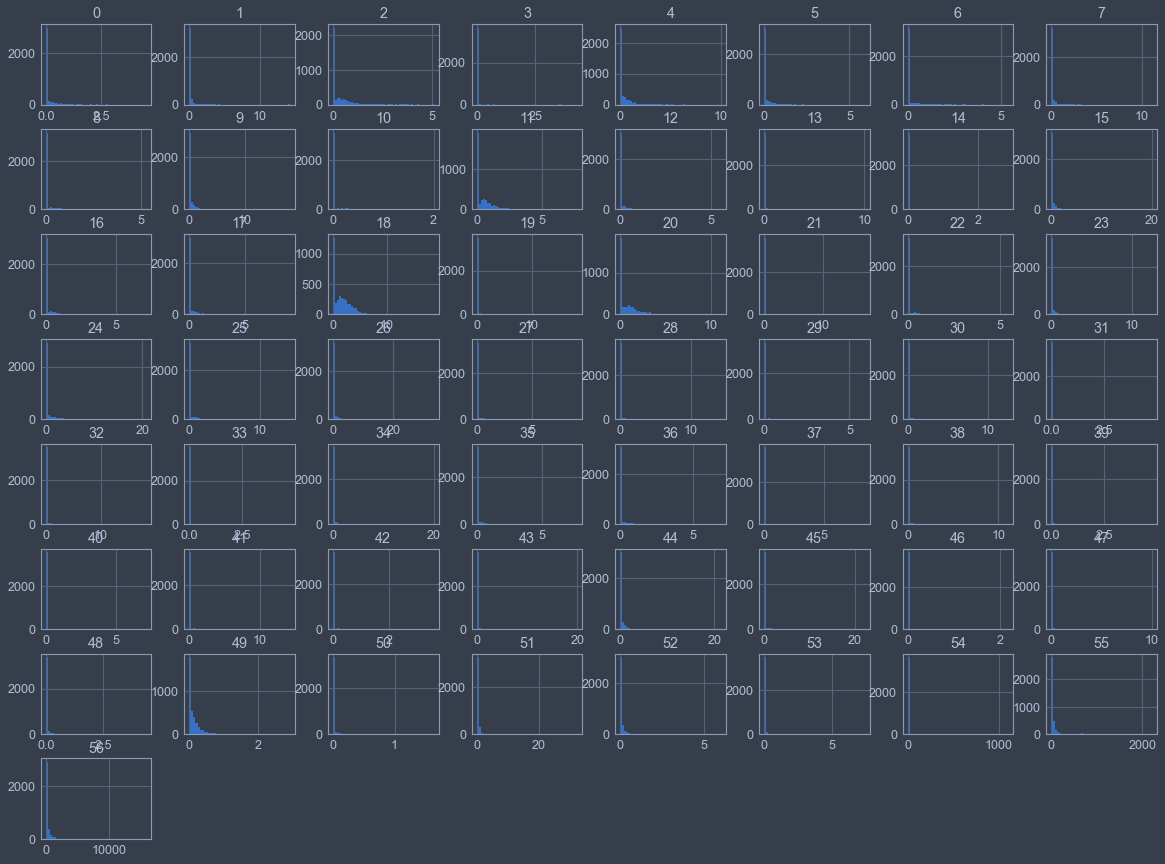

In [11]:
train_X_2.hist(bins = 50, figsize=(20,15))
plt.show()

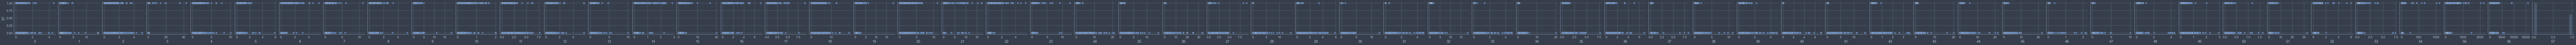

In [12]:
sns.pairplot(train_set_2, y_vars=57, x_vars=train_set_2.columns.values)

In [16]:
train_set_2[57].value_counts()

0    2245
1    1435
Name: 57, dtype: int64

In [9]:
#### Nested Grid Search

#Defining the 4 classifiers and also adding min max scaling before every 
    #classifier fitting in the cross validation as the models 
    #knn requires minmaxscaling, 
    #logistic regression and svc require normalization

#Applying scaling in the inner loop before training the model

clf_1 = Pipeline([('scaler', None), ('model', DecisionTreeClassifier())])

clf_2 = Pipeline([('scaler', MinMaxScaler()), ('model', KNeighborsClassifier())])

clf_3 = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression())])

clf_4 = Pipeline([('scaler', StandardScaler()), ('model', SVC())])

clf_5 = Pipeline([('scaler', None), ("model", GaussianNB())])

clf_6 = Pipeline([('scaler', None), ("model", RandomForestClassifier())])

clf_7 = Pipeline([("scaler", None), ("model", AdaBoostClassifier())])

clf_8 = Pipeline([("scaler", None), ("model", GradientBoostingClassifier())])

clf_9 = Pipeline([("scaler", StandardScaler()), ("model", XGBClassifier())])

# clf_11 = Pipeline([("scaler", None), ("model", StackingClassifier)])

clf_10 = Pipeline([("scaler", StandardScaler()), ("model", LGBMClassifier())])

In [ ]:
#Defining parameter grids for grid search
classifier_dict_base = {
    #Decision Trees
    clf_1 : {
        "model__criterion" : ["gini", "entropy"],
        "model__max_depth" : list(range(3, 8))
    },
    #KNN
    clf_2 : {
        "model__n_neighbors" : list(range(3, 8)),
        "model__weights" : ["distance", "uniform"]
    },
    #Logistic Regression
    clf_3 : 
    [
          {
              "model__penalty": ["l1"], 
              "model__solver": ["liblinear"], 
              "model__C" : [0.01, 0.1, 1, 10, 100], 
              "model__tol" : [1e-3, 1e-4], 
              "model__max_iter" : [100, 1000]
          },
          {
              "model__penalty": ["l2"],
              "model__solver": ["lbfgs"],
              "model__C" : [0.01, 0.1, 1, 10, 100], 
              "model__tol" : [1e-3, 1e-4], 
              "model__max_iter" : [100, 1000]
          },
          {
              "model__penalty" : ["elasticnet"],
              "model__C" : [0.01, 0.1, 1, 10, 100],
              "model__tol" : [1e-3, 1e-4],
              "model__solver" : ["saga"],
              "model__max_iter" : [100, 1000],
              "model__l1_ratio" : [0.2, 0.5, 0.8]
          }
    ],
    #SVM
    clf_4 : {
        "model__C" : [0.01, 0.1, 1, 10, 100],
        "model__kernel" : ["linear", "rbf"],
        "model__gamma" : ["auto", "scale"]
    },
    #Gaussian NB
    clf_5 : {
        "model__var_smoothing : [1e-8, 1e-9, 1e-10]"
    },
    #Random Forest Classifier
    clf_6 : 
    {
        "model__n_estimators" : [100, 300, 500],
        "model__criterion" : ["gini", "entropy"],
        "model__max_depth" : list(range(3, 10)),
        "model__oob_score" : [True, False],
        "model__max_features" : ["auto", "log2"],
        "model__min_samples_leaf" : [10, 20, 30]
    },
    #AdaBoost Classification
    clf_7 : {
        "model__base_estimator" : [DecisionTreeClassifier(max_depth=1), GaussianNB(), LogisticRegression(), SVC()],
        "model__n_estimators" : [100, 1000],
        "model__learning_rate" : [0.03, 0.3, 1, 3],
    },
    #GradientBoost Classification
    clf_8 : {
        "model__n_estimators" : [100, 300, 500],
        "model__learning_rate" : [0.1, 1, 0.01],
        "model__loss" : ["deviance", "exponential"],
        "model__criterion" : ["friedman_mse", "squared_error"],
        "model__max_features" : ["auto", "log2"],
        "model__min_samples_leaf" : [10, 20, 30]
        },
    #XGBoost Classification
    clf_9 : {
        "model__use_label_encoder": [False],
        'model__max_depth': list(range(3, 12)),
        "model__learning_rate" : [0.1, 1, 0.01],
        'model__n_estimators': [10, 100, 500],
        'model__colsample_bytree': [0.3, 0.7, 1],
        "model__min_sample_weight" : list(range(1, 12)),
        "model__gamma" : [0, 10, 100, 500, 1000]
    },
    #LGBM Classification
    clf_10 : {
        "model__n_estimators" : [100, 300, 500],
        "model__max_depth" : list(range(3, 12)),
        "model__learning_rate" : [0.1, 0.3, 1, 0.01],
        "model__num_leaves" : [20, 50, 100, 200, 500, 1000],
        "model__min_data_in_leaf" : [200, 500, 1000, 3000, 7000]
    }
    # clf_11
    #StackingRegressor
}

In [11]:
classifier_dict = copy.copy(classifier_dict_base)

In [13]:
custom_scorer_2 = make_scorer(accuracy_score)

In [14]:
classifiers_q2 = [
    "DecisionTreeClassifier", 
    "KNeighborsClassifier",
    "LogisticRegression",
    "SVC",
    "AdaBoostClassifier",
    "RandomForestClassifier",
    "GradientBoostingClassifier",
    "XGBClassifier",
    "LGBMClassifier"
]

In [18]:
nested_scores_2 = nested_cross_validation(train_X_2, \
    train_Y_2, classifiers_q2, custom_scorer_2, classifier_dict)

Currently Executing:- 
Pipeline(steps=[('scaler', None), ('model', DecisionTreeClassifier())]) {'model__criterion': ['gini', 'entropy'], 'model__max_depth': [3, 4, 5, 6, 7]}
Currently Executing:- 
Pipeline(steps=[('scaler', MinMaxScaler()), ('model', KNeighborsClassifier())]) {'model__n_neighbors': [3, 4, 5, 6, 7], 'model__weights': ['distance', 'uniform']}
Currently Executing:- 
Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())]) [{'model__penalty': ['l1'], 'model__solver': ['liblinear'], 'model__C': [0.01, 0.1, 1, 10, 100], 'model__tol': [0.001, 0.0001], 'model__max_iter': [100, 1000]}, {'model__penalty': ['l2'], 'model__solver': ['lbfgs'], 'model__C': [0.01, 0.1, 1, 10, 100], 'model__tol': [0.001, 0.0001], 'model__max_iter': [100, 1000]}, {'model__penalty': ['elasticnet'], 'model__C': [0.01, 0.1, 1, 10, 100], 'model__tol': [0.001, 0.0001], 'model__solver': ['saga'], 'model__max_iter': [100, 1000], 'model__l1_ratio': [0.2, 0.5, 0.8]}]


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Currently Executing:- 
Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())]) {'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'model__kernel': ['linear', 'rbf'], 'model__gamma': ['auto', 'scale']}


KeyboardInterrupt: 

In [95]:
best_clf = get_best_model_classification(train_X_2, train_Y_2, test_X_2, test_Y_2, \
                          classifier_dict, nested_scores_2, custom_scorer_2)

C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: Use

[20:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: Use

[20:35:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:35:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:35:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: Use

[20:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rahul\.conda\envs\pred\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:36:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
******************CONFUSION MATRIX******************
[[521  22]
 [ 23 355]]
****************CLASIFICATION REPORT****************
                    0           1  accuracy   macro avg  weighted avg
precision    0.957721    0.941645   0.95114    0.949683      0.951123
recall       0.959484    0.939153   0.95114    0.949319      0.951140
f1-score     0.958602    0.940397   0.951

In [96]:
best_clf

Pipeline(steps=[('scaler', None),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=7, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [107]:
nested_scores_2

[(Pipeline(steps=[('scaler', None), ('model', RandomForestClassifier())]),
  0.9323369565217392),
 (Pipeline(steps=[('scaler', None), ('model', AdaBoostClassifier())]),
  0.9432065217391304),
 (Pipeline(steps=[('scaler', None), ('model', GradientBoostingClassifier())]),
  0.9489130434782609)]

In [93]:
nested_scores_2

[(Pipeline(steps=[('scaler', None), ('model', DecisionTreeClassifier())]),
  0.9067934782608696),
 (Pipeline(steps=[('scaler', MinMaxScaler()),
                  ('model',
                   KNeighborsClassifier(n_neighbors=4, weights='distance'))]),
  0.9019021739130435),
 (Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())]),
  0.9260869565217391),
 (Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())]),
  0.9296195652173913),
 (Pipeline(steps=[('scaler', None), ('model', GradientBoostingClassifier())]),
  nan),
 (Pipeline(steps=[('scaler', None),
                  ('model',
                   XGBClassifier(base_score=None, booster=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None, enable_categorical=False,
                                 gamma=None, gpu_id=None, importance_type=None,
                                 interaction_constraints=None, learning_

In [119]:
def cost_function(y_test, y_predicted):
    """
        Custom cost function as different misclassifications have different penalties to them
        In our case FN is ten times more expensive than FP
    """
    cost = 0

    for y_true, y_pred in zip(y_test, y_predicted):

        # if y_true == 0 and y_pred == 0:
            # cost += 1
        if y_true == 0 and y_pred == 1:
            cost += 1
        elif y_true == 1 and y_pred == 0:
            cost += 10
        # elif y_true == 1 and y_pred == 1:
            # cost += 1

    # print("Cost: " + str(cost))
    return cost

In [121]:
custom_scorer_2_b = make_scorer(cost_function, greater_is_better=False)

In [120]:
classifiers_q2 = [
    "DecisionTreeClassifier", 
    "KNeighborsClassifier",
    "LogisticRegression",
    "SVC",
    "AdaBoostClassifier",
    "RandomForestClassifier",
    "GradientBoostingClassifier",
    "XGBClassifier"
]

In [122]:
nested_scores_2 = nested_cross_validation(train_X_2, \
    train_Y_2, classifiers_q2, custom_scorer_2_b, classifier_dict)

Currently Executing:- 
Pipeline(steps=[('scaler', None), ('model', DecisionTreeClassifier())]) {'model__criterion': ['gini', 'entropy'], 'model__max_depth': [3, 4, 5, 6, 7]}
Currently Executing:- 
Pipeline(steps=[('scaler', MinMaxScaler()), ('model', KNeighborsClassifier())]) {'model__n_neighbors': [3, 4, 5, 6, 7], 'model__weights': ['distance', 'uniform']}
Currently Executing:- 
Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())]) [{'model__penalty': ['l1'], 'model__solver': ['liblinear'], 'model__C': [0.01, 0.1, 1, 10, 100, 1000], 'model__tol': [0.001, 0.0001], 'model__max_iter': [100, 1000]}, {'model__penalty': ['l2'], 'model__solver': ['lbfgs'], 'model__C': [0.01, 0.1, 1, 10, 100, 1000], 'model__tol': [0.001, 0.0001], 'model__max_iter': [100, 1000]}, {'model__penalty': ['elasticnet'], 'model__C': [0.01, 0.1, 1, 10, 100, 1000], 'model__tol': [0.001, 0.0001], 'model__solver': ['saga'], 'model__max_iter': [100, 1000], 'model__l1_ratio': [0.2, 0.5, 0.8]}]


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Currently Executing:- 
Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())]) {'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'model__kernel': ['linear', 'rbf'], 'model__gamma': ['auto', 'scale']}
Currently Executing:- 
Pipeline(steps=[('scaler', None), ('model', RandomForestClassifier())]) {'model__n_estimators': [100, 300, 500], 'model__criterion': ['gini', 'entropy'], 'model__max_depth': [3, 4, 5, 6, 7, 8, 9], 'model__oob_score': [True, False], 'model__max_features': ['auto', 'log2'], 'model__min_samples_leaf': [10, 20, 30]}
Currently Executing:- 
Pipeline(steps=[('scaler', None), ('model', AdaBoostClassifier())]) {'model__base_estimator': [DecisionTreeClassifier(max_depth=1), GaussianNB(), LogisticRegression(), SVC()], 'model__n_estimators': [100, 1000], 'model__learning_rate': [0.03, 0.3, 1, 3]}


C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\rahul\.conda\envs\pred\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Currently Executing:- 
Pipeline(steps=[('scaler', None),
                ('model',
                 GradientBoostingClassifier(max_features='log2',
                                            min_samples_leaf=10,
                                            n_estimators=500))]) {'model__n_estimators': [100, 300, 500], 'model__learning_rate': [0.1, 1, 0.01], 'model__loss': ['deviance', 'exponential'], 'model__criterion': ['friedman_mse', 'squared_error'], 'model__max_features': ['auto', 'log2'], 'model__min_samples_leaf': [10, 20, 30]}
Currently Executing:- 
Pipeline(steps=[('scaler', None),
                ('model',
                 XGBClassifier(base_score=None, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, enable_categorical=False,
                               gamma=None, gpu_id=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None

In [112]:
import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 5000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [123]:
nested_scores_2

[(Pipeline(steps=[('scaler', None), ('model', DecisionTreeClassifier())]),
  -532.5),
 (Pipeline(steps=[('scaler', MinMaxScaler()), ('model', KNeighborsClassifier())]),
  -525.75),
 (Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())]),
  -426.0),
 (Pipeline(steps=[('scaler', StandardScaler()), ('model', SVC())]), -399.0),
 (Pipeline(steps=[('scaler', None), ('model', RandomForestClassifier())]),
  -467.25),
 (Pipeline(steps=[('scaler', None), ('model', AdaBoostClassifier())]), -359.0),
 (Pipeline(steps=[('scaler', None),
                  ('model',
                   GradientBoostingClassifier(max_features='log2',
                                              min_samples_leaf=10,
                                              n_estimators=500))]),
  -261.75),
 (Pipeline(steps=[('scaler', None),
                  ('model',
                   XGBClassifier(base_score=None, booster=None,
                                 colsample_bylevel=None, colsample_bynode=N

In [124]:
best_clf = get_best_model_classification(train_X_2, train_Y_2, test_X_2, test_Y_2, \
                          classifier_dict, nested_scores_2, custom_scorer_2)

******************CONFUSION MATRIX******************
[[521  22]
 [ 23 355]]
****************CLASIFICATION REPORT****************
                    0           1  accuracy   macro avg  weighted avg
precision    0.957721    0.941645   0.95114    0.949683      0.951123
recall       0.959484    0.939153   0.95114    0.949319      0.951140
f1-score     0.958602    0.940397   0.95114    0.949500      0.951130
support    543.000000  378.000000   0.95114  921.000000    921.000000


In [115]:
best_clf

Pipeline(steps=[('scaler', None),
                ('model',
                 GradientBoostingClassifier(max_features='log2',
                                            min_samples_leaf=10,
                                            n_estimators=500))])

In [117]:
winsound.Beep(2500, 5000)